In [7]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from dotenv import load_dotenv
from pathlib import Path

In [8]:
API_URL='https://data-charts-api.hexlet.app'
DATE_BEGIN='2023-03-01'
DATE_END='2023-06-01'

C:\Users\nurla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nurla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nurla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nurla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

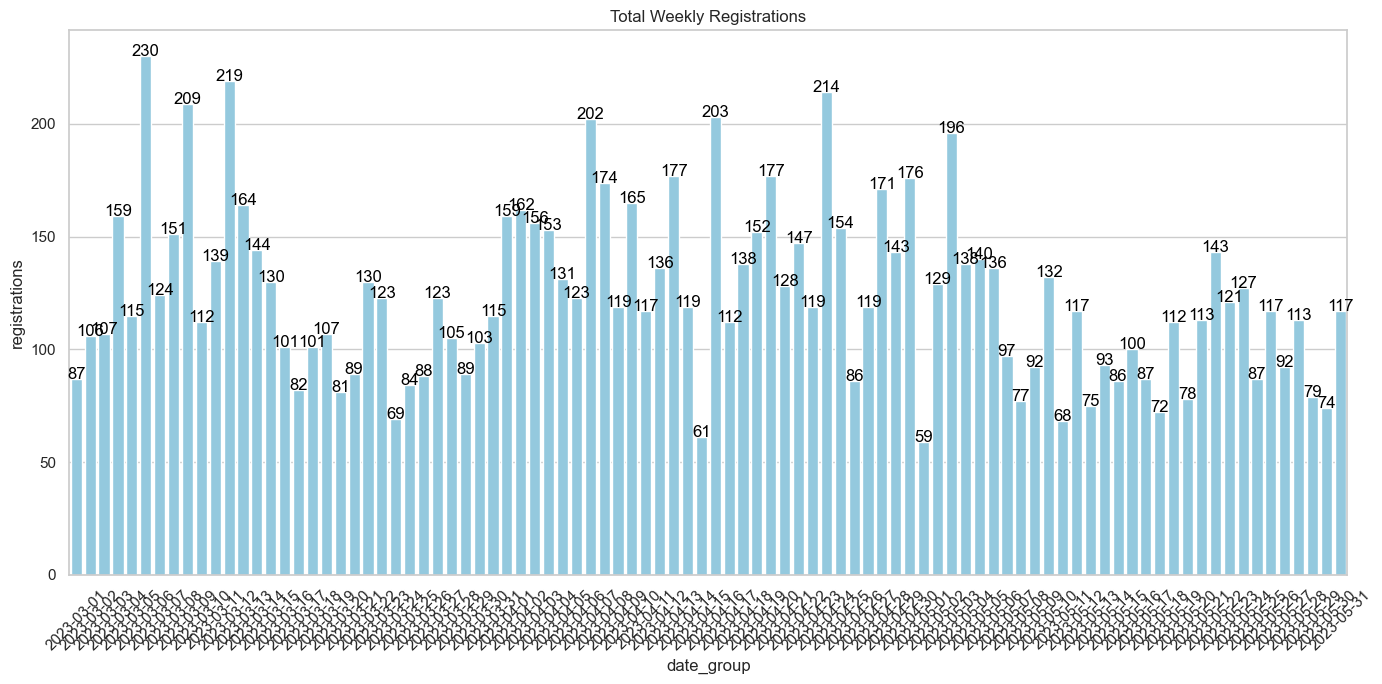

<Figure size 1400x700 with 0 Axes>

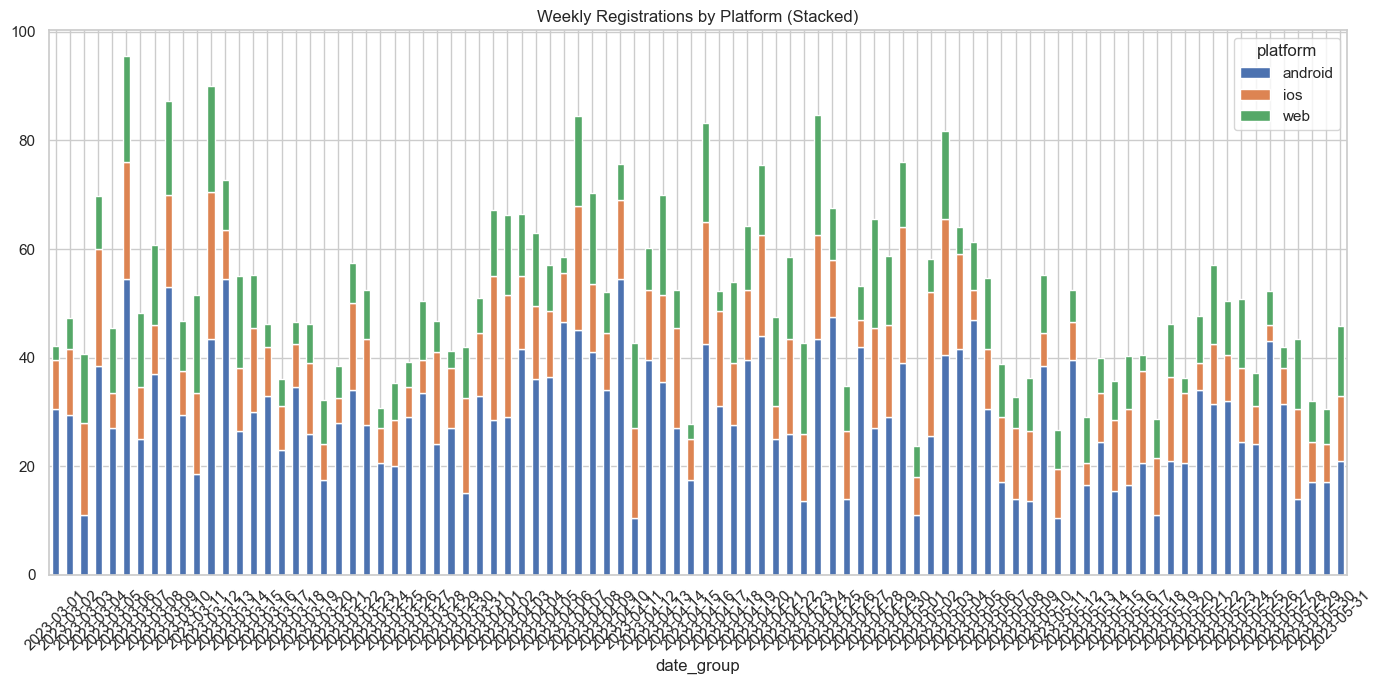

<Figure size 1400x700 with 0 Axes>

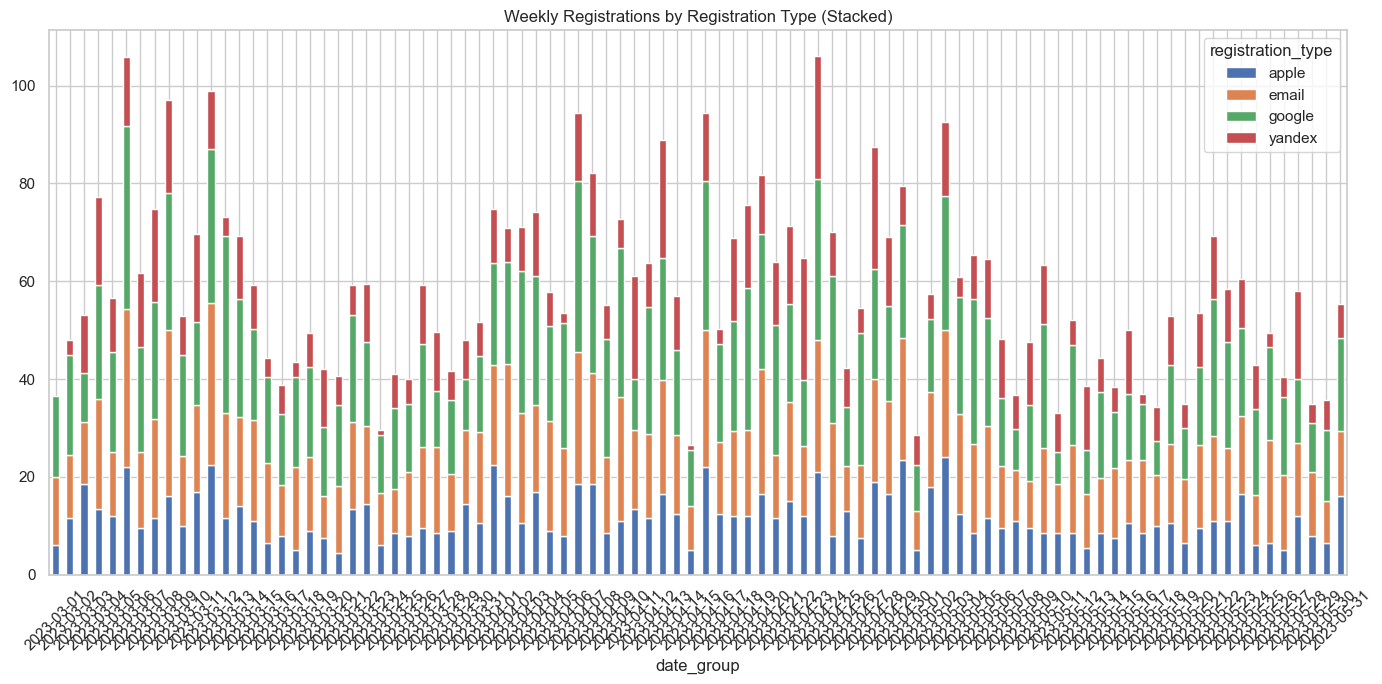

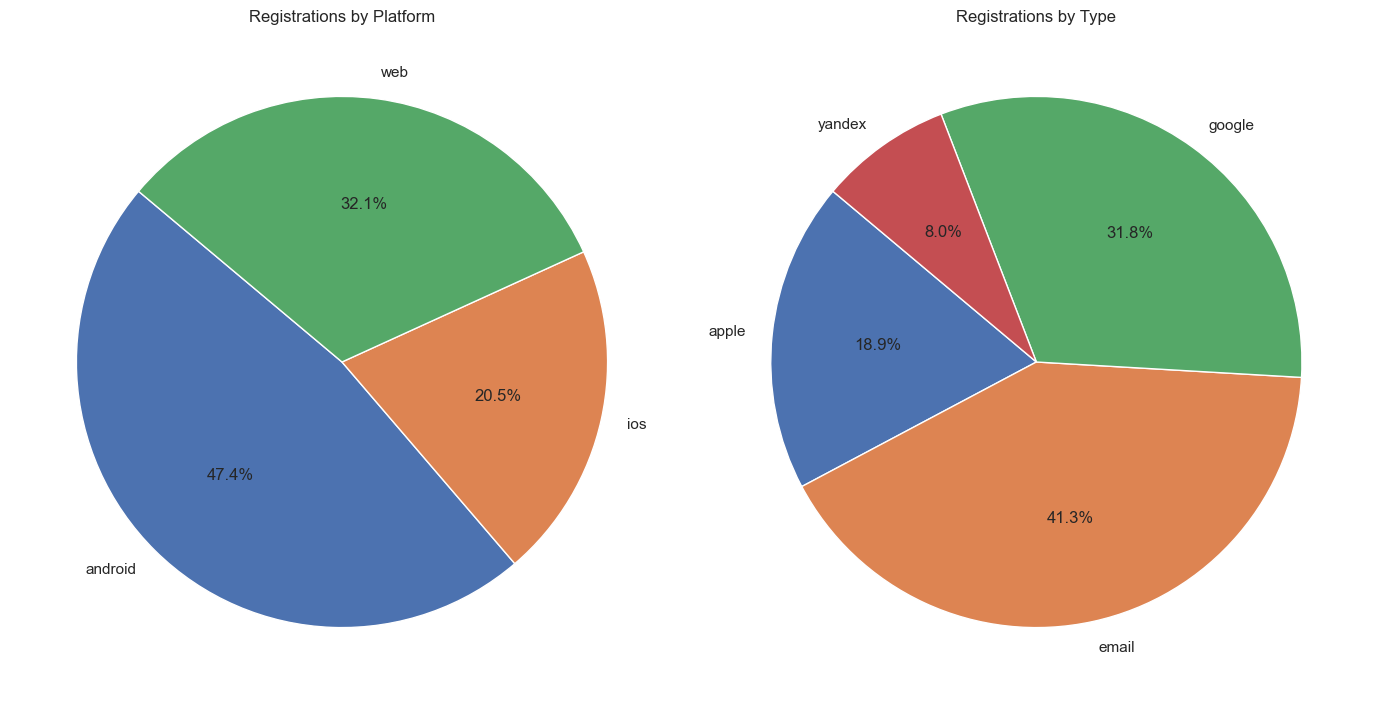

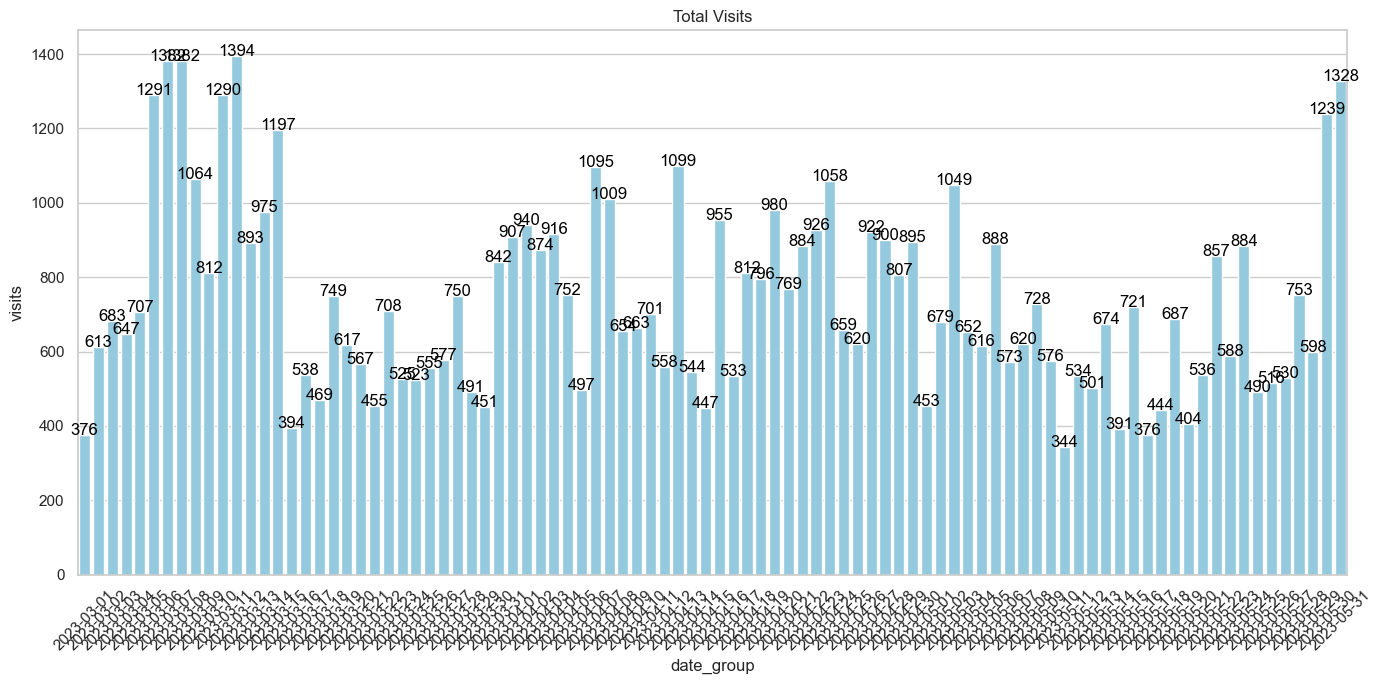

<Figure size 1400x700 with 0 Axes>

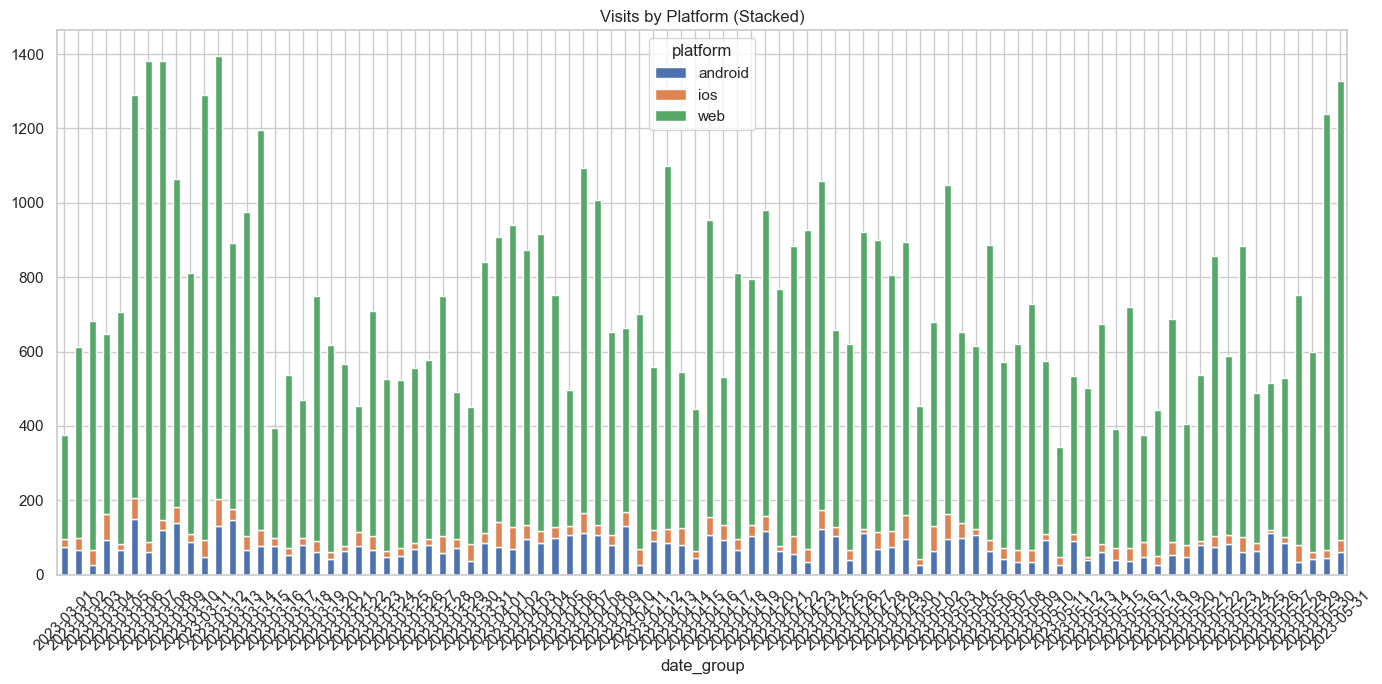

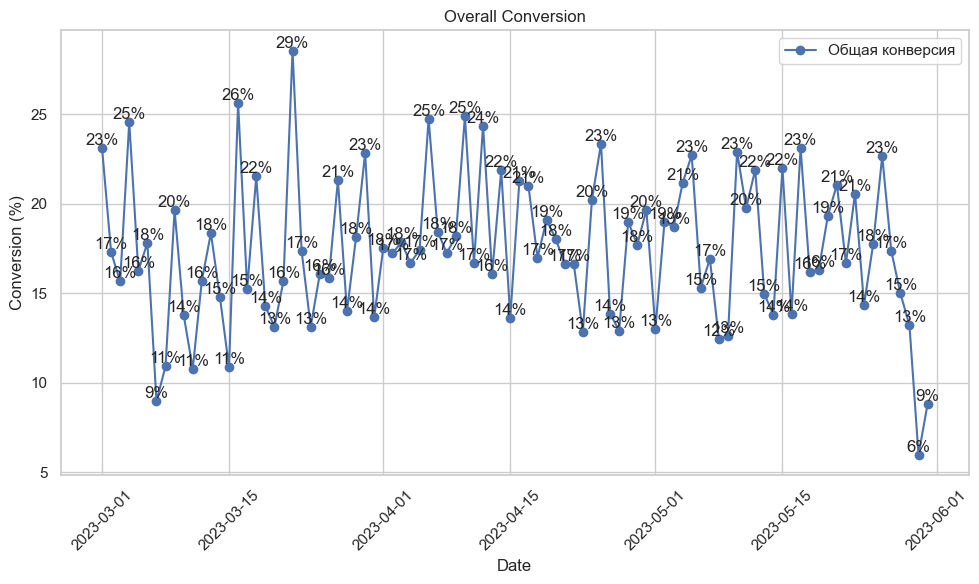

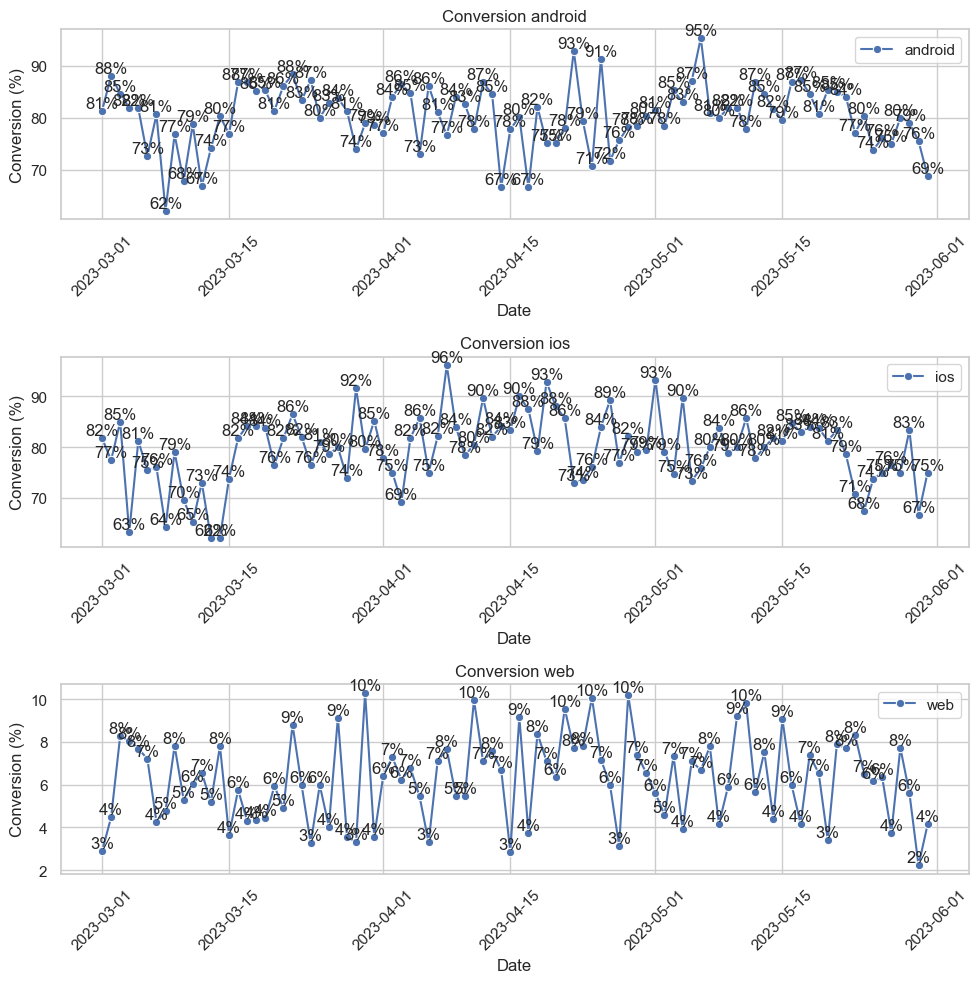

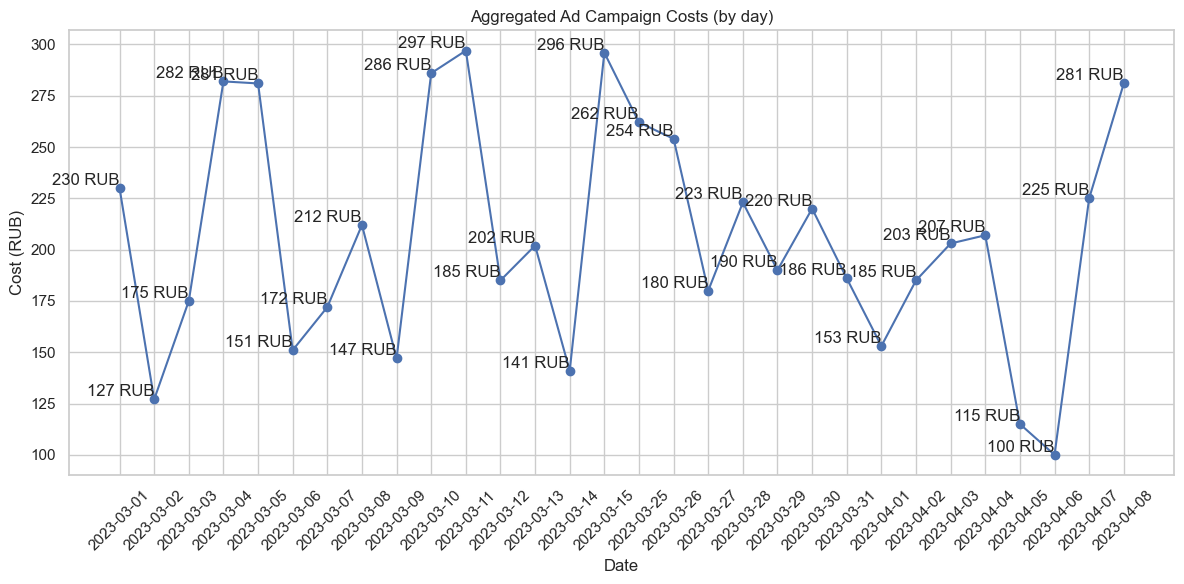

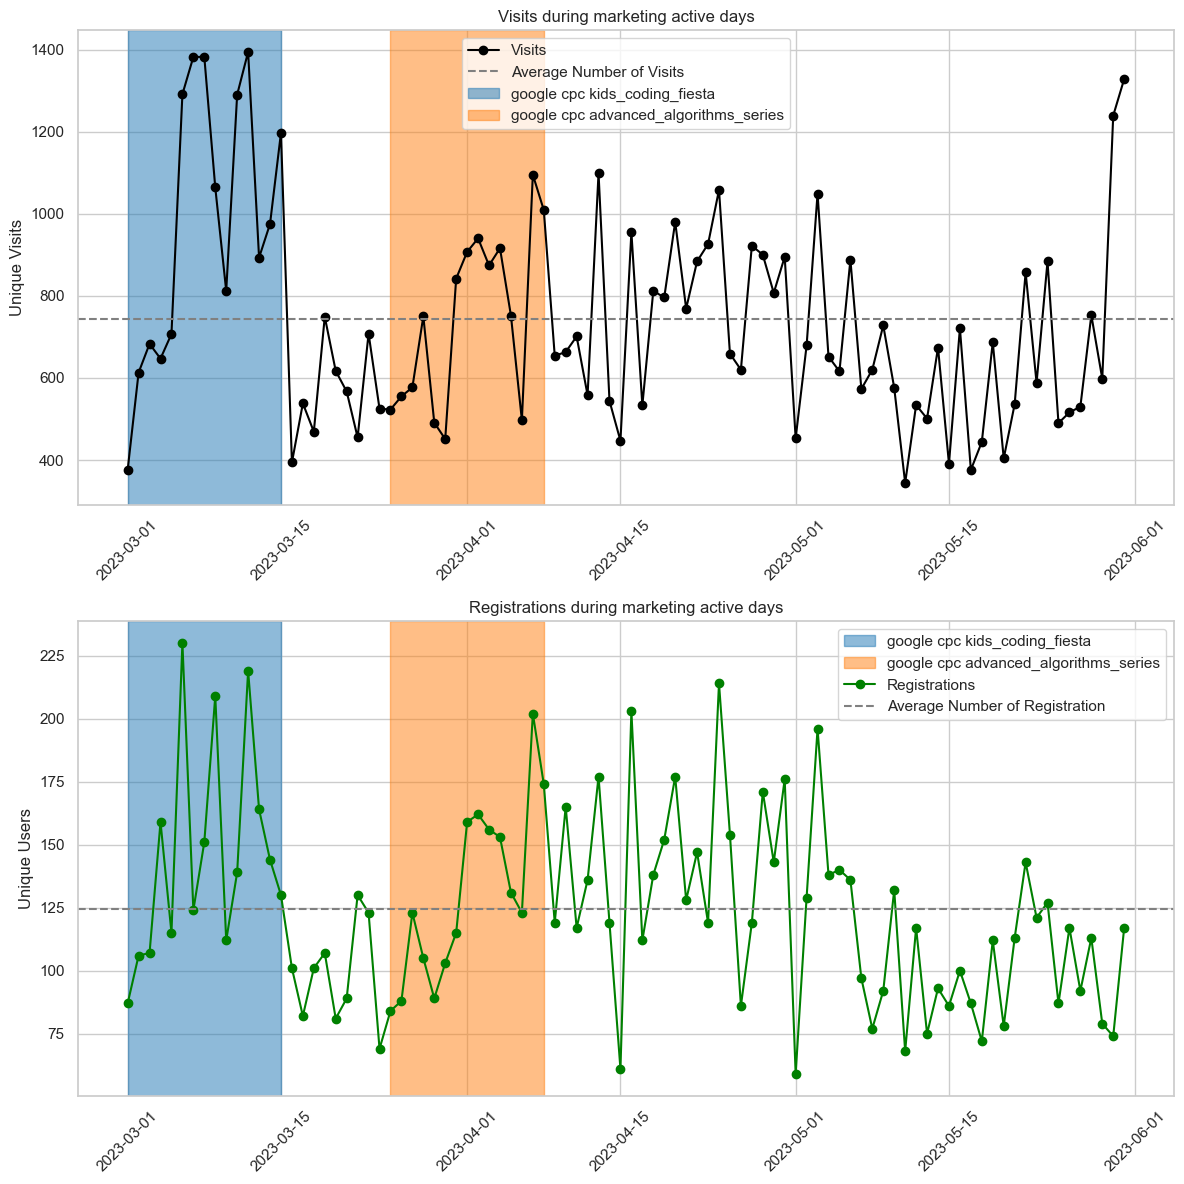

In [9]:
def main():
    p = Path.cwd()
    d = p / 'charts'
    d.mkdir(exist_ok=True)
    date_start = DATE_BEGIN
    date_end = DATE_END
    date_group = 'day'
    run_and_analyze(date_start, date_end, date_group)


def run_and_analyze(date_start, date_end, date_group):
    resp = requests.get(f'{API_URL}/registrations', params={'begin': date_start, 'end': date_end})
    regs = pd.DataFrame(resp.json())

    resp = requests.get(f'{API_URL}/visits', params={'begin': date_start, 'end': date_end})
    visits = pd.DataFrame(resp.json())

    regs.rename(columns={'datetime': 'registration_dt'}, inplace=True)
    visits.rename(columns={'visit_id': 'anonymous_id', 'datetime': 'visit_dt'}, inplace=True)

    ads_column_names = ['date', 'source', 'medium', 'campaign', 'cost']
    ads = pd.read_csv('./ads.csv', names=ads_column_names, header=None)

    clean_regs = clean_registration_data(regs)
    aggregated_df_with_regtype, aggregated_df_without_regtype = filter_and_aggregate_registration_data(clean_regs,
                                                                                                       date_start,
                                                                                                       date_end,
                                                                                                       date_group)
    if not aggregated_df_with_regtype.empty:
        visualize_aggregated_registration_data(aggregated_df_with_regtype)

    clean_visits = clean_visit_data(visits)
    aggregated_visits = filter_and_aggregate_visit_data(clean_visits, date_start, date_end, date_group)
    if not aggregated_visits.empty:
        visualize_aggregated_visits_data(aggregated_visits)

    if not (aggregated_df_without_regtype.empty or aggregated_visits.empty):
        conversion = merge_dataframes_and_calculate_conversion(aggregated_visits, aggregated_df_without_regtype)
        plot_conversion_graphs(conversion)

    ads_data_cleaned = clean_ads_data(ads)
    aggregated_ads_data, df_ads_aggregated_with_ads = filter_and_aggregate_ads_data(ads_data_cleaned, date_start, date_end, date_group)
    if not aggregated_ads_data.empty:
        visualize_aggregated_ads_data(aggregated_ads_data, date_group)

    df_ads_periods = get_continuous_campaign_periods(df_ads_aggregated_with_ads, date_group)
    visualize_combined_data(aggregated_visits, aggregated_df_without_regtype, df_ads_periods)
    #sns.set(style="whitegrid")


def clean_registration_data(df):
    # Remove duplicates
    df_cleaned = df.drop_duplicates()

    # Fill empty values in 'platform' with 'web'
    df_cleaned['platform'] = df_cleaned['platform'].fillna('web')

    return df_cleaned


def clean_visit_data(df):

    df_cleaned = df.copy()
    #print('TOTAL_VISITS = ', len(df_cleaned))
    # Convert 'visit_dt' to datetime
    #try:
    df_cleaned['visit_dt'] = pd.to_datetime(df_cleaned['visit_dt'])
    #except Exception as e:
    #    print('visit_dt id not in datetime format')

    df_cleaned = df_cleaned.sort_values(by=['anonymous_id', 'visit_dt']).drop_duplicates(subset='anonymous_id', keep='last')
    #df_cleaned.sort_values(by='anonymous_id').to_csv('./test.csv')

    # Filter out rows where 'user_agent' contains 'bot' (indicating bots)
    df_cleaned = df_cleaned[~df_cleaned['user_agent'].str.contains('bot')]

    # Remove extra characters around 'platform' values
    df_cleaned['platform'] = df_cleaned['platform'].str.strip("`")

    return df_cleaned


def filter_and_aggregate_registration_data(df, date_start, date_end, date_group):
    # Convert the start and end dates from strings to datetime objects
    date_start = pd.to_datetime(date_start)
    date_end = pd.to_datetime(date_end)

    # Convert the registration dates from strings to datetime objects
    if 'registration_dt' in df.columns:
        df['registration_dt'] = pd.to_datetime(df['registration_dt'], errors='coerce')
    else:
        raise ValueError("'registration_dt' column not found in the DataFrame")

    # Filter the dataframe for the date range
    mask = (df['registration_dt'] >= date_start) & (df['registration_dt'] <= date_end)
    filtered_df = df.loc[mask].copy()

    #if filtered_df.empty:
    #    print('There is no registrations in given date range')
    #    return pd.DataFrame(), pd.DataFrame()
    # Group the data according to the date_group parameter
    #if date_group == 'day':
    filtered_df['date_group'] = filtered_df['registration_dt'].dt.to_period('D').dt.start_time.dt.date
    #elif date_group == 'week':
    #    filtered_df['date_group'] = filtered_df['registration_dt'].dt.to_period('W').dt.start_time.dt.date
    #elif date_group == 'month':
    #    filtered_df['date_group'] = filtered_df['registration_dt'].dt.to_period('M').dt.start_time.dt.date
    #elif date_group == 'quarter':
    #    filtered_df['date_group'] = filtered_df['registration_dt'].dt.to_period('Q').dt.start_time.dt.date

    # Aggregate the data
    aggregated_df_with_regtype = filtered_df.groupby(['date_group', 'platform', 'registration_type']) \
        .size().reset_index(name='registrations')

    aggregated_df_without_regtype = filtered_df.groupby(['date_group', 'platform']) \
        .size().reset_index(name='registrations')

    # Sort the dataframe by date_group
    aggregated_df_with_regtype = aggregated_df_with_regtype.sort_values(by='date_group')
    aggregated_df_without_regtype = aggregated_df_without_regtype.sort_values(by='date_group')

    return aggregated_df_with_regtype, aggregated_df_without_regtype


def filter_and_aggregate_visit_data(df, date_start, date_end, date_group):
    date_start_format = pd.to_datetime(date_start)
    date_end_format = pd.to_datetime(date_end)

    # Filter the dataframe for dates within the specified range
    mask = (df['visit_dt'] >= date_start_format) & (df['visit_dt'] <= date_end_format)
    df_filtered = df.loc[mask].copy()

    #if len(df_filtered) == 0:
    #    print('There is no visits in given date range')
    #    return pd.DataFrame()

    # Group by the specified date group and platform, and count visits
    #if date_group == 'day':
    df_filtered['date_group'] = df_filtered['visit_dt'].dt.to_period('D').dt.start_time.dt.date
    #elif date_group == 'week':
    #   df_filtered['date_group'] = df_filtered['visit_dt'].dt.to_period('W').dt.start_time.dt.date
    #elif date_group == 'month':
    #   df_filtered['date_group'] = df_filtered['visit_dt'].dt.to_period('M').dt.start_time.dt.date
    #elif date_group == 'quarter':
    #   df_filtered['date_group'] = df_filtered['visit_dt'].dt.to_period('Q').dt.start_time.dt.date

    # Aggregate data
    df_aggregated = df_filtered.groupby(['date_group', 'platform']).size().reset_index(name='visits')

    return df_aggregated


def visualize_aggregated_registration_data(aggregated_data):
    # aggregated_data['date_group'] = aggregated_data['date_group'].dt.date

    # Set the aesthetic style of the plots
    #sns.set_style("whitegrid")

    # Create a bar chart for total registrations by date_group without any breakdown
    plt.figure(figsize=(14, 7))
    total_registrations_by_date = aggregated_data.groupby('date_group').registrations.sum().reset_index()
    sns.barplot(data=total_registrations_by_date, x='date_group', y='registrations', color='skyblue')
    plt.title('Total Weekly Registrations')
    for index, row in total_registrations_by_date.iterrows():
        plt.text(row.name, row.registrations, round(row.registrations, 2), color='black', ha="center")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./charts/total_registrations.png')
    # plt.show()

    # Create stacked bar charts for registrations by date_group with breakdown by platform and registration_type
    # For platform
    plt.figure(figsize=(14, 7))
    platform_breakdown = aggregated_data.pivot_table(index='date_group', columns='platform', values='registrations',
                                                     fill_value=0)
    platform_breakdown.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title('Weekly Registrations by Platform (Stacked)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./charts/total_registrations_by_platform.png')
    # plt.show()

    # For registration_type
    plt.figure(figsize=(14, 7))
    reg_type_breakdown = aggregated_data.pivot_table(index='date_group', columns='registration_type',
                                                     values='registrations', fill_value=0)
    reg_type_breakdown.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title('Weekly Registrations by Registration Type (Stacked)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./charts/total_registrations_by_type.png')
    # plt.show()

    # Create pie charts for platform and registration_type distributions without confidence intervals
    platform_pie = aggregated_data.groupby('platform').registrations.sum()
    reg_type_pie = aggregated_data.groupby('registration_type').registrations.sum()

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].pie(platform_pie, labels=platform_pie.index, autopct='%1.1f%%', startangle=140)
    ax[0].set_title('Registrations by Platform')
    ax[1].pie(reg_type_pie, labels=reg_type_pie.index, autopct='%1.1f%%', startangle=140)
    ax[1].set_title('Registrations by Type')
    plt.tight_layout()
    plt.savefig(f'./charts/total_registrations_by_type_pie.png')
    # plt.show()


def visualize_aggregated_visits_data(aggregated_data):
    # aggregated_data['date_group'] = aggregated_data['date_group'].dt.date

    plt.figure(figsize=(14, 7))
    total_visits_by_date = aggregated_data.groupby('date_group').visits.sum().reset_index()
    sns.barplot(data=total_visits_by_date, x='date_group', y='visits', color='skyblue')
    plt.title('Total Visits')
    plt.xticks(rotation=45)
    for index, row in total_visits_by_date.iterrows():
        plt.text(row.name, row.visits, round(row.visits, 2), color='black', ha="center")
    plt.tight_layout()
    plt.savefig(f'./charts/total_visits.png')
    # plt.show()

    plt.figure(figsize=(14, 7))
    visit_platfom_breakdown = aggregated_data.pivot_table(index='date_group', columns='platform', values='visits',
                                                          fill_value=0)
    visit_platfom_breakdown.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title('Visits by Platform (Stacked)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./charts/total_visits_by_platform.png')
    # plt.show()


def merge_dataframes_and_calculate_conversion(df_visits, df_registrations):
    # Объединение датафреймов по дате и платформе
    merged_df = pd.merge(df_visits, df_registrations, on=['date_group', 'platform'])

    # Расчет конверсии
    merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100
    merged_df.to_json('conversion.json')
    return merged_df


def plot_conversion_graphs(df):

    # График общей конверсии по всем платформам
    plt.figure(figsize=(10, 6))
    overall_conversion = df.groupby('date_group').sum()
    overall_conversion['conversion'] = overall_conversion['registrations'] / overall_conversion['visits'] * 100
    overall_conversion = overall_conversion[['conversion']]
    plt.plot(overall_conversion.index, overall_conversion['conversion'], marker='o', color='b', label='Общая конверсия')
    for i in range(len(overall_conversion)):
        plt.text(overall_conversion.index[i], overall_conversion['conversion'].iloc[i],
                 f"{overall_conversion['conversion'].iloc[i]:.0f}%", ha='center', va='bottom')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.title('Overall Conversion')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./charts/conversion.png')
    # plt.show()

    # Графики конверсии по каждой платформе
    platforms = df['platform'].unique()

    plt.figure(figsize=(10, 10))
    for i, platform in enumerate(platforms, 1):
        plt.subplot(len(platforms), 1, i)
        platform_data = df[df['platform'] == platform]
        sns.lineplot(x='date_group', y='conversion', data=platform_data, marker='o', label=platform)
        for x, y in platform_data[['date_group', 'conversion']].values:
            plt.text(x, y, f'{y:.0f}%', ha='center', va='bottom')
        plt.xlabel('Date')
        plt.ylabel('Conversion (%)')
        plt.title(f'Conversion {platform}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./charts/conversion_by_platforms.png')
    # plt.show()


def clean_ads_data(df):
    df = df.drop_duplicates()
    df['date'] = pd.to_datetime(df['date'])
    return df


def filter_and_aggregate_ads_data(df, date_start, date_end, date_group):
    date_start = pd.to_datetime(date_start)
    date_end = pd.to_datetime(date_end)

    df_filtered = df[(df['date'] >= date_start) & (df['date'] <= date_end)].copy()

    #if len(df_filtered) == 0:
    #    print('There is no ads cost in given date range')
    #    return pd.DataFrame()

    #if date_group == 'day':
    df_filtered['date_group'] = df_filtered['date'].dt.to_period('D').dt.start_time.dt.date
    #elif date_group == 'week':
    #   df_filtered['date_group'] = df_filtered['date'].dt.to_period('W').dt.start_time.dt.date
    #elif date_group == 'month':
    #   df_filtered['date_group'] = df_filtered['date'].dt.to_period('M').dt.start_time.dt.date
    #elif date_group == 'quarter':
    #    df_filtered['date_group'] = df_filtered['date'].dt.to_period('Q').dt.start_time.dt.date

    df_filtered['full_ad'] = df_filtered['source'] + " " + df_filtered['medium'] + " " + df_filtered['campaign']
    df_aggregated = df_filtered.groupby(['date_group']).sum(numeric_only=True).reset_index()
    df_ads_aggregated = df_filtered.groupby(['date_group', 'full_ad']).sum(numeric_only=True).reset_index()

    return df_aggregated, df_ads_aggregated

def visualize_aggregated_ads_data(df, date_group):
    #sns.set(style="whitegrid")
    x = df['date_group'].astype(str)
    y = df['cost']
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, marker='o', color='b')

    for i, label in enumerate(y):
        plt.text(x[i], y[i], f'{label} RUB', ha='right', va='bottom')

    plt.xlabel('Date')
    plt.ylabel('Cost (RUB)')
    plt.title(f'Aggregated Ad Campaign Costs (by {date_group})')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(f'./charts/ads_cost.png')


def get_continuous_campaign_periods(df, date_group):
    day = {'day': 1, 'week': 7, 'month': 30, 'quarter': 180}

    periods_df = pd.DataFrame()

    for campaign in df['full_ad'].unique():
        campaign_data = df[df['full_ad'] == campaign].copy()
        campaign_data.sort_values('date_group', inplace=True)
        campaign_data['gap'] = campaign_data['date_group'].diff().dt.days > day[date_group]
        campaign_data['period'] = campaign_data['gap'].cumsum()
        campaign_periods = campaign_data.groupby('period').agg(start=('date_group', 'min'), end=('date_group', 'max'))
        campaign_periods['campaign'] = campaign
        periods_df = pd.concat([periods_df, campaign_periods.reset_index(drop=True)])

    return periods_df


def visualize_combined_data(aggregated_visits, aggregated_df_without_regtype, df_ads_periods):
    plt.figure(figsize=(12, 12))
    campaign_colors = dict(zip(df_ads_periods['campaign'].unique(),
                               mcolors.TABLEAU_COLORS))

    plt.subplot(2, 1, 1)
    total_visits_by_date = aggregated_visits.groupby('date_group').visits.sum().reset_index()
    plt.plot(total_visits_by_date['date_group'], total_visits_by_date['visits'], color='black', label='Visits',
             marker='o')
    # plt.plot(aggregated_visits['date_group'], aggregated_visits['visits'], marker='o', color='b', label='Заходы')
    # plt.plot(daily_costs['date'].unique(), average_conversion, label='Average Conversion', color='black')
    plt.axhline(y=total_visits_by_date['visits'].mean(), color='gray', linestyle='--', label="Average Number of Visits")
    # plt.text(total_visits_by_date['date_group'].max(), total_visits_by_date['visits'].mean(),
    #          'Average Number of Visits: ' + str(int(total_visits_by_date['visits'].mean())), color='dimgray',
    #          ha='right', va='bottom', fontsize=12)

    for _, row in df_ads_periods.iterrows():
        plt.axvspan(row['start'], row['end'], label=row['campaign'], color=campaign_colors[row['campaign']], alpha=0.5)
    plt.title('Visits during marketing active days')
    plt.ylabel('Unique Visits')
    plt.xticks(rotation=45)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.subplot(2, 1, 2)

    for _, row in df_ads_periods.iterrows():
        plt.axvspan(row['start'], row['end'], label=row['campaign'], color=campaign_colors[row['campaign']], alpha=0.5)

    total_registrations_by_date = aggregated_df_without_regtype.groupby('date_group').registrations.sum().reset_index()
    plt.plot(total_registrations_by_date['date_group'], total_registrations_by_date['registrations'], color='green',
             label='Registrations', marker='o')

    plt.xticks(rotation=45)
    # plt.plot(aggregated_visits['date_group'], aggregated_visits['visits'], marker='o', color='b', label='Заходы')
    # plt.plot(daily_costs['date'].unique(), average_conversion, label='Average Conversion', color='black')
    plt.axhline(y=total_registrations_by_date['registrations'].mean(), color='gray', linestyle='--', label='Average Number of Registration')
    # plt.text(total_registrations_by_date['date_group'].max(), total_registrations_by_date['registrations'].mean(),
    #          'Average Number of Registration: ' + str(int(total_registrations_by_date['registrations'].mean())),
    #          color='dimgray', ha='right', va='bottom', fontsize=10)

    plt.title('Registrations during marketing active days')
    plt.ylabel('Unique Users')
    plt.xticks(rotation=45)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.savefig(f'./charts/activity_during_marketing_campaign.png')

main()